In [30]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

ERROR! Session/line number was not unique in database. History logging moved to new session 151


# Integrated gradients

## Resources

- [Axiomatic attribution for deep networks](https://arxiv.org/abs/1703.01365)
- [Going deeper with convolutions](https://arxiv.org/abs/1409.4842)
- [Attribution baselines](https://distill.pub/2020/attribution-baselines/)
- [Riemann sum](https://en.wikipedia.org/wiki/Riemann_sum)

We will walk through IG step-by-step to understand the pixel feature importances of an image classifier. Let's have a look at this image.

<img src = "../../assets/fireboat.png" width="500" height="400">

We will see:

- What is important for classifying this image as an image with a fireboat.

### Download a pretrained image classifier from TF-Hub

In [31]:
inception_v1 = tf.keras.Sequential([
    hub.KerasLayer(name='inception_v1', 
    handle='https://tfhub.dev/google/imagenet/inception_v1/classification/4', 
    trainable=False)
])
inception_v1.build([None, 224, 224, 3])
inception_v1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v1 (KerasLayer)    (None, 1001)              6633209   
Total params: 6,633,209
Trainable params: 0
Non-trainable params: 6,633,209
_________________________________________________________________


**Inputs**: The input shape for the model is `(None, 224, 224, 3)` 

**Outputs**: 
 - A `tf.Tensor` of logits in the shape of `(batch_size, 1001)`. 
 - Each row is for one of the 1,001 classes from ImageNet. 
 - Top predicted -`tf.argmax(predictions, axis=-1)`.
 - Prediction probabilities - `tf.nn.softmax(predictions, axis=-1)`

Function for loading the labels of ImageNet dataset.

In [32]:
def load_imagenet_labels(file_path):
    labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)
    with open(labels_file) as reader:
        f = reader.read()
        labels = f.splitlines()
    return np.array(labels)

In [33]:
imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

In [34]:
imagenet_labels

array(['background', 'tench', 'goldfish', ..., 'bolete', 'ear',
       'toilet tissue'], dtype='<U30')

### Load and preprocess images

Let's illustrate IG using two images from [Wikimedia Commons](https://commons.wikimedia.org/wiki/Main_Page): a [Fireboat](https://commons.wikimedia.org/wiki/File:San_Francisco_fireboat_showing_off.jpg), a [Giant Panda](https://commons.wikimedia.org/wiki/File:Giant_Panda_2.JPG)

In [35]:
def read_image(file_name):
    image = tf.io.read_file(file_name)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
    return image

In [36]:
img_url = {
    'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
    'Giant Panda': 'http://storage.googleapis.com/download.tensorflow.org/example_images/Giant_Panda_2.jpeg',
}

img_paths = {name: tf.keras.utils.get_file(name, url) for (name, url) in img_url.items()}
img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_paths.items()}

Two downloaded images are below.

In [37]:
img_name_tensors

{'Fireboat': <tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0.,

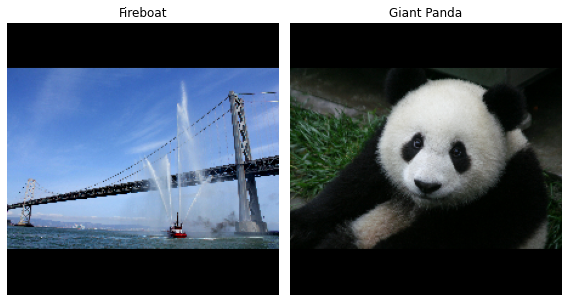

In [38]:
plt.figure(figsize=(8, 8))
for n, (name, img_tensors) in enumerate(img_name_tensors.items()):
    ax = plt.subplot(1, 2, n+1)
    ax.imshow(img_tensors)
    ax.set_title(name)
    ax.axis('off')
plt.tight_layout()

### Classify images
We can classifying these images and display the top 3 most confident predictions. The function top_k_predicted shows the top labels and probabilities of predictions.

In [39]:
def top_k_predictions(img, k=3):
    # Add batch dim for the model to be able to predict
    image_batch = tf.expand_dims(img, axis=0)
    predictions = inception_v1(image_batch)
    probs = tf.nn.softmax(predictions, axis=-1)
    top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
    top_labels = imagenet_labels[tuple(top_idxs)]
    return top_labels, top_probs[0] 

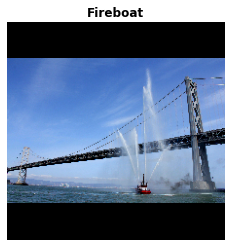

fireboat: 32.6%
pier: 12.7%
suspension bridge: 5.7%


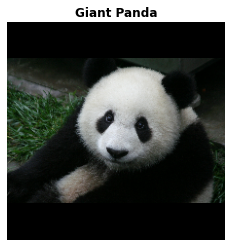

giant panda: 89.4%
teddy: 0.3%
gibbon: 0.3%


In [40]:
for (name, img_tensor) in img_name_tensors.items():
    plt.imshow(img_tensor)
    plt.title(name, fontweight='bold')
    plt.axis('off')
    plt.show()

    pred_label, pred_prob = top_k_predictions(img_tensor)
    for label, prob in zip(pred_label, pred_prob):
        print(f'{label}: {prob:0.1%}')

## Intuition behind Integrated Gradients

- Our model, Inception V1, is a function mapping the input feature space, values of image pixels, to the output space defined by ImageNet class probabilitiy values in $[0, 1]$ range.
- Earlier methods described feature importance using gradients w.r.t. pixels multiplied by pixels values, similar to coefficients of features in Linear Regression. A gradient is telling us which pixels have the steepest local slope with respect to the output
- The gradients of input features may have small magnitudes even if the network depends heavily on those features. This can happen if the network function flattens after those features reach a certain magnitude. The gradients *saturate*.

In [41]:
def f(x):
  """A simplified model function."""
  return tf.where(x < 0.8, x, 0.8)

def interpolated_path(x):
  """A straight line path."""
  return tf.zeros_like(x)

x = tf.linspace(start=0.0, stop=1.0, num=6)
y = f(x)

Plot gradients and IG intuition.

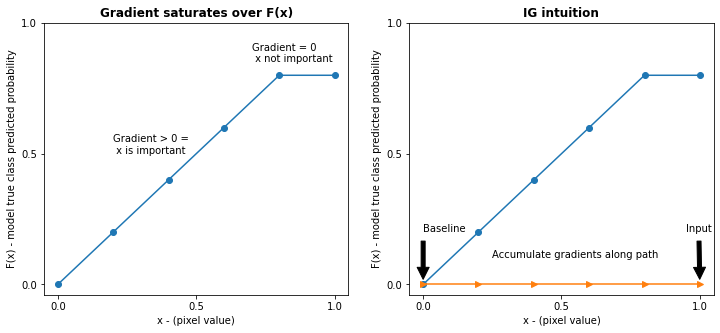

In [42]:
fig = plt.figure(figsize=(12, 5))
ax0 = fig.add_subplot(121)
ax0.plot(x, f(x), marker='o')
ax0.set_title('Gradient saturates over F(x)', fontweight='bold')
ax0.text(0.2, 0.5, 'Gradient > 0 = \n x is important')
ax0.text(0.7, 0.85, 'Gradient = 0 \n x not important')
ax0.set_yticks(tf.range(0, 1.5, 0.5))
ax0.set_xticks(tf.range(0, 1.5, 0.5))
ax0.set_ylabel('F(x) - model true class predicted probability')
ax0.set_xlabel('x - (pixel value)')

ax1 = fig.add_subplot(122)
ax1.plot(x, f(x), marker='o')
ax1.plot(x, interpolated_path(x), marker='>')
ax1.set_title('IG intuition', fontweight='bold')
ax1.text(0.25, 0.1, 'Accumulate gradients along path')
ax1.set_ylabel('F(x) - model true class predicted probability')
ax1.set_xlabel('x - (pixel value)')
ax1.set_yticks(tf.range(0, 1.5, 0.5))
ax1.set_xticks(tf.range(0, 1.5, 0.5))
ax1.annotate('Baseline', xy=(0.0, 0.0), xytext=(0.0, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
ax1.annotate('Input', xy=(1.0, 0.0), xytext=(0.95, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.show();

* **left**: 
- The model's gradients for pixel `x` are positive between 0.0 and 0.8 but go to 0.0 between 0.8 and 1.0. 
- Pixel `x` has a significant impact on pushing the model toward 80% predicted probability on the true class. 
- *It doesn't make sense that pixel `x`'s importance is small*.

* **right**:
- Which pixels, when scaled along this path, most increased the network output for the correct class?
- IG accumulate pixel `x`'s local gradients and attribute its importance as a score for how much it adds or subtracts to the model's overall output class probability. Let's break down and compute IG in 3 parts: 

    1. Interpolate small steps along a straight line in the feature space between 0 (a baseline or starting point) and 1 (input pixel's value) 
    2. compute gradients at each step for the model's predictions with respect to each step.
    3. approximate the integral between the baseline and the input by accumulating (cumulative average) these local gradients.

### Establish a baseline

- A baseline is an input image used as a starting point for calculating feature importance.
- Shows the impact of the absence of each pixel on the prediction to contrast with its impact of each pixel on the prediction when present in the input image.
- The choice of the baseline plays a central role in interpreting and visualizing pixel feature importances.
- Let's use a black image here whose pixel values are all zeros.

In [43]:
baseline = tf.zeros(shape=(224, 224, 3))

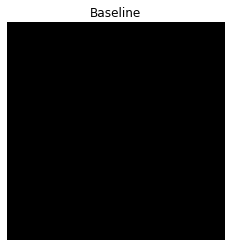

In [44]:
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

### Convert formulas into code

The formula for Integrated Gradients is as follows:

$IntegratedGrads_{i}(x) ::= (x_{i} - x'_{i})\times\int_{\alpha=0}^1\frac{\partial F(x'+\alpha \times (x - x'))}{\partial x_i}{d\alpha}$

where:

$_{i}$ = feature   
$x$ = input  
$x'$ = baseline that represents the "absence" of a feature   
$\alpha$ = interpolation constant for feature perturbation

In practice, computing a definite integral is not always numerically possible and can be computationally costly, so you compute the following numerical approximation:

$IntegratedGrads^{approx}_{i}(x)::=(x_{i}-x'_{i})\times\sum_{k=1}^{m}\frac{\partial F(x' + \frac{k}{m}\times(x - x'))}{\partial x_{i}} \times \frac{1}{m}$

where:

$_{i}$ = feature (individual pixel)  
$x$ = input (image tensor)  
$x'$ = baseline (image tensor)  
$k$ = scaled feature perturbation constant  
$m$ = number of steps in the Riemann sum approximation of the integral  
$(x_{i}-x'_{i})$ = a term for the difference from the baseline. 

### Interpolate images

$IntegratedGrads^{approx}_{i}(x)::=(x_{i}-x'_{i})\times\sum_{k=1}^{m}\frac{\partial F(\overbrace{x' + \frac{k}{m}\times(x - x')}^\text{interpolate m images at k intervals})}{\partial x_{i}} \times \frac{1}{m}$

- Let's generate a [linear interpolation](https://en.wikipedia.org/wiki/Linear_interpolation) between the baseline and the original image. 
- You can think of interpolated images as small steps in the feature space between the baseline and the input, represented by $\alpha$ in the original equation.

In [45]:
alphas = tf.linspace(start=0.0, stop=1.0, num=51)

In [46]:
def interpolate_images(baseline,
                       image,
                       alphas):
    # Make alphas 4 dimensional to match the dimensions of our images and the baseline
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    # Batch dim for the baseline and the image
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(image, axis=0)
    # Pixel change between the image and baseline
    delta = input_x - baseline_x
    # Get interpolated images
    images = baseline_x +  alphas_x * delta
    return images

Let's use the above function to generate interpolated images along a linear path at alpha intervals between a black baseline image and the example "Fireboat" image.

In [47]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=img_name_tensors['Fireboat'],
    alphas=alphas)

Let's visualize the interpolated images. 
- Another way of thinking about the $\alpha$ constant is that it is consistently increasing each interpolated image's intensity.

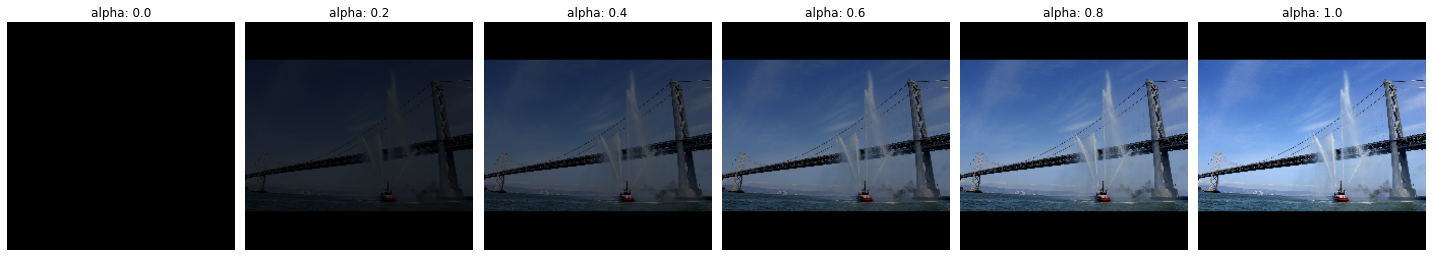

In [48]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
    i += 1
    plt.subplot(1, len(alphas[0::10]), i)
    plt.title(f'alpha: {alpha:.1f}')
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout();

### Compute gradients

- Let's see how to calculate gradients in order to measure the relationship between changes to a feature and changes in the model's predictions. 
- For images, the gradient tells us which pixels have the strongest effect on the models predicted class probabilities.

$IntegratedGrads^{approx}_{i}(x)::=(x_{i}-x'_{i})\times\sum_{k=1}^{m}\frac{\overbrace{\partial F(\text{interpolated images})}^\text{compute gradients}}{\partial x_{i}} \times \frac{1}{m}$

where:  
$F()$ = your model's prediction function  
$\frac{\partial{F}}{\partial{x_i}}$ = gradient (vector of partial derivatives $\partial$) of your model F's prediction function relative to each feature $x_i$.

We will use `tf.GradientTape` to compute gradients.

In [49]:
def compute_gradients(model, images, target_class_idx):
    with tf.GradientTape() as tape:
        # We use tape.watch here to tell Tensorflow GradientTape to trace all operations with the tensor 'images'
        # When we train a model this step is not needed, since all trainable variables are "watched" automatically
        tape.watch(images)
        logits = model(images)
        probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
    return tape.gradient(probs, images)

- Let's compute gradients for each image along the interpolation path with respect to the correct output.

In [50]:
path_gradients = compute_gradients(
    model=inception_v1,
    images=interpolated_images,
    target_class_idx=tf.constant(555)
)

In [51]:
print(path_gradients.shape)

(51, 224, 224, 3)


**Output dims**

- 51 interpolated images
- Height of the images
- Width of the images
- RGB channels

We have a gradient for every pixel of all 51 interpolated images. The gradients essentially measure the change in your model's predictions for each small step in the feature space.

#### Visualizing gradient saturation

- These gradients describe *local* changes to the model's predicted probability of "Fireboat" and can *saturate*.

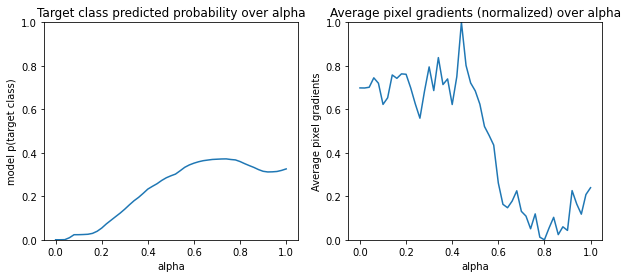

In [52]:
pred = inception_v1(interpolated_images)
pred_proba = tf.nn.softmax(pred, axis=-1)[:, 555]

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);

- The model "learns" the most from gradients at lower values of alpha. 
- For example, the gradients of the pixels of water cannons are sent to zero to make the correct prediction.
- However it's still quite uncertain and focused on the bridge or water jet pixels as the alpha values approach the original input image.

How to make sure that the correct pixels, e.g. of water cannons, are reflected as important for the prediction?

### Accumulate gradients (integral approximation)

- We will use Riemann sum to approximate IGs.

$IntegratedGrads^{approx}_{i}(x)::=(x_{i}-x'_{i})\times \overbrace{\sum_{k=1}^{m}}^\text{Sum m local gradients}
\text{gradients(interpolated images)} \times \overbrace{\frac{1}{m}}^\text{Divide by m steps}$

- We can implement the above formula as an *average of the local gradients of `m` interpolated predictions and input images*.

In [53]:
def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

In [54]:
ig = integral_approximation(gradients=path_gradients)

In [55]:
print(ig.shape)

(224, 224, 3)


### Putting it all together

- Let's write a function to compute integrated gradients

$IntegratedGrads^{approx}_{i}(x)::=\overbrace{(x_{i}-x'_{i})}^\text{5.}\times \overbrace{\sum_{k=1}^{m}}^\text{4.} \frac{\partial \overbrace{F(\overbrace{x' + \overbrace{\frac{k}{m}}^\text{1.}\times(x - x'))}^\text{2.}}^\text{3.}}{\partial x_{i}} \times \overbrace{\frac{1}{m}}^\text{4.}$

1. Generate alphas $\alpha$

2. Generate interpolated images = $(x' + \frac{k}{m}\times(x - x'))$

3. Compute gradients between model $F$ output predictions with respect to input features = $\frac{\partial F(\text{interpolated path inputs})}{\partial x_{i}}$

4. Average integral approximation = $\sum_{k=1}^m \text{gradients} \times \frac{1}{m}$

5. The term for the difference between the image and the baseline that scales integrated gradients with respect to imput.

In [56]:
def integrated_gradients(model, baseline, image, target_class_idx, m_steps=300, batch_size=32):
    
    # 1. Generate alphas
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps)

    # Accumulate gradients across batches
    integrated_gradients = 0.0

    # Batch alpha images
    ds = tf.data.Dataset.from_tensor_slices(alphas).batch(batch_size)

    for batch in ds:

        # 2. Generate interpolated images
        batch_interpolated_inputs = interpolate_images(
            baseline=baseline,
            image=image,
            alphas=batch
        )

        # 3. Compute gradients between model outputs and interpolated inputs
        batch_gradients = compute_gradients(
            model=model,
            images=batch_interpolated_inputs,
            target_class_idx=target_class_idx
        )

        # 4. Average integral approximation. Summing integrated gradients across batches.
        integrated_gradients += integral_approximation(gradients=batch_gradients)

    # 5. Scale integrated gradients with respect to input
    scaled_integrated_gradients = (image - baseline) * integrated_gradients
        
    return scaled_integrated_gradients

In [57]:
ig_attributions = integrated_gradients(
    model=inception_v1,
    baseline=baseline,
    image=img_name_tensors['Fireboat'],
    target_class_idx=555
)

- Check that the IG feature attributions have the same shape as the input "Fireboat" image.

In [27]:
print(ig_attributions.shape)

(224, 224, 3)


### Visualize attributions

- Visualize attributions
- Overlay them on the original image. 
- The code below sums the absolute values of the integrated gradients across the color channels to produce an attribution mask. 

In [28]:
def plot_img_attributions(model, baseline, image, target_class_idx, m_steps=tf.constant(50), cmap=None, overlay_alpha=0.4):

    attributions = integrated_gradients(
        model=model,
        baseline=baseline,
        image=image,
        target_class_idx=target_class_idx,
        m_steps=m_steps
    )

    # Sum of the attributions across color channels for visualization.
    # The attribution mask is a grayscale image with height and width
    # equal to the original image.
    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

    fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

    axs[0, 0].set_title('Baseline image')
    axs[0, 0].imshow(baseline)
    axs[0, 0].axis('off')

    axs[0, 1].set_title('Original image')
    axs[0, 1].imshow(image)
    axs[0, 1].axis('off')

    axs[1, 0].set_title('Attribution mask')
    axs[1, 0].imshow(attribution_mask, cmap=cmap)
    axs[1, 0].axis('off')

    axs[1, 1].set_title('Overlay')
    axs[1, 1].imshow(attribution_mask, cmap=cmap)
    axs[1, 1].imshow(image, alpha=overlay_alpha)
    axs[1, 1].axis('off')

    plt.tight_layout()
    return fig

Looking at the attributions on the "Fireboat" image, we can see the model identifies the water cannons and spouts as contributing to its correct prediction.

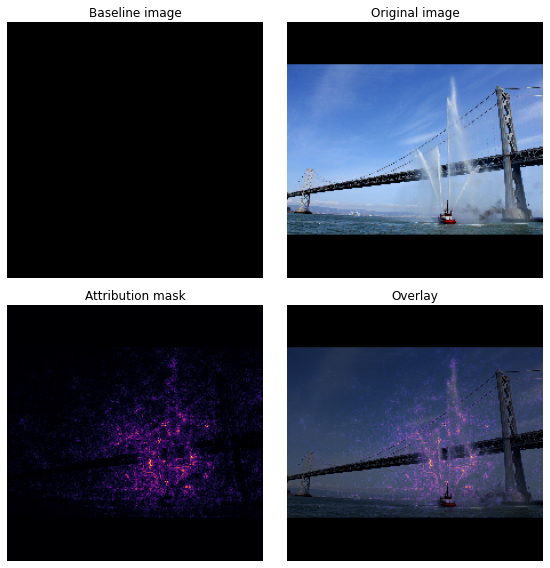

In [29]:
_ = plot_img_attributions(
    model=inception_v1,
    image=img_name_tensors['Fireboat'],
    baseline=baseline,
    target_class_idx=555,
    m_steps=2400,
    cmap=plt.cm.inferno,
    overlay_alpha=0.4
)

On the "Giant Panda" image, the attributions highlight the texture, nose, and the fur of the Panda's face.

Get 2 new images for the exercise.

In [58]:
img_url_ex = {
    'Black Beetle': 'https://storage.googleapis.com/applied-dl/temp/Lucanus.jpeg',
    'Goldfinch': 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRF0_JmbeAmqCG9XUObIrN9CTgwRzUZycFKOQ&usqp=CAU'
}

img_paths_ex = {name: tf.keras.utils.get_file(name, url) for (name, url) in img_url_ex.items()}
img_name_tensors_ex = {name: read_image(img_path) for (name, img_path) in img_paths_ex.items()}

## Exercise

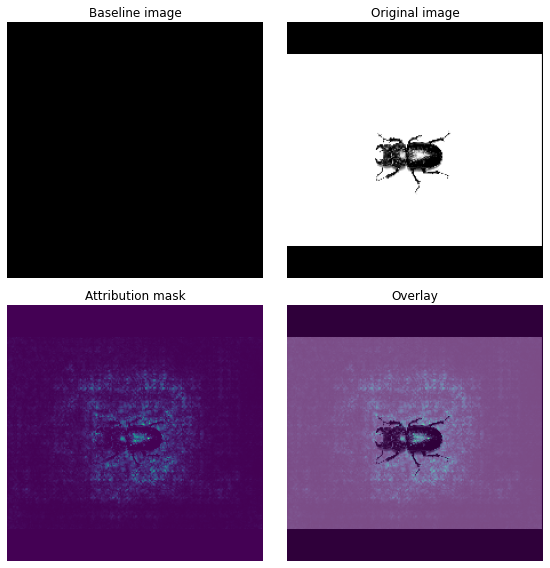

In [59]:
# Plot the beetle with a black baseline
_ = plot_img_attributions(
    model=inception_v1,
    image=img_name_tensors_ex['Black Beetle'],
    baseline=baseline,
    target_class_idx=307,
    m_steps=3500,
    cmap=plt.cm.viridis,
    overlay_alpha=0.3
)

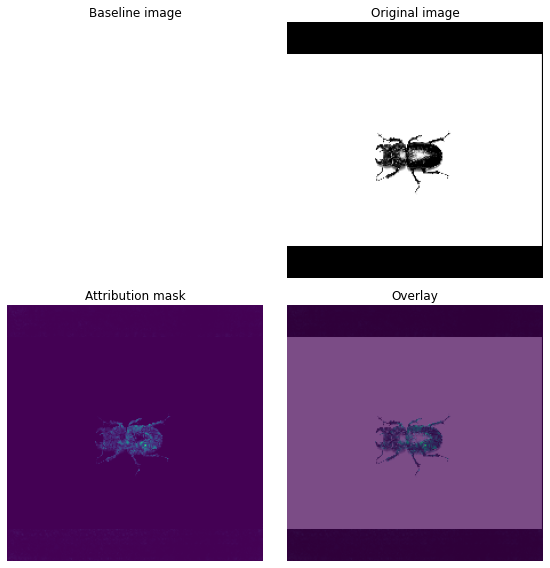

In [60]:
# White baseline for the beetle
_ = plot_img_attributions(
    model=inception_v1,
    image=img_name_tensors_ex['Black Beetle'],
    baseline=tf.ones_like(img_name_tensors_ex['Black Beetle']),
    target_class_idx=307,
    m_steps=3000,
    cmap=plt.cm.viridis,
    overlay_alpha=0.3
)


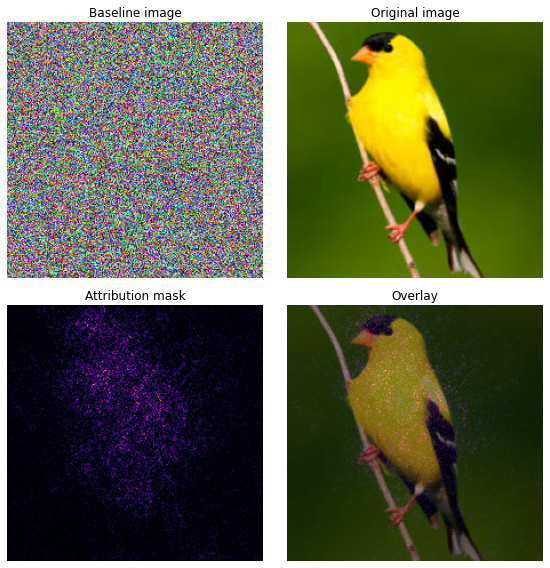

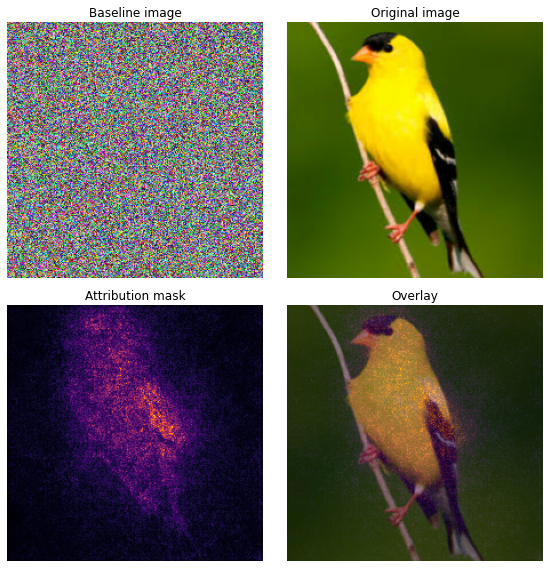

In [61]:
# Uniform baseline
uniform_baseline = tf.random.uniform((224, 224, 3), 0, 1)

_ = plot_img_attributions(
    model=inception_v1,
    image=img_name_tensors_ex['Goldfinch'],
    baseline=uniform_baseline,
    target_class_idx=12,
    m_steps=500,
    cmap=plt.cm.inferno,
    overlay_alpha=0.5
)

# Attributions from 5 uniform baselines averaged
attributions = np.zeros((5, 224, 224, 3))
attribution_masks = np.zeros((5, 224, 224))

for i in range(5):
    baseline = tf.random.uniform((224, 224, 3), 0, 1)
    
    attributions[i] = integrated_gradients(
            model=inception_v1,
            baseline=baseline,
            image=img_name_tensors_ex['Goldfinch'],
            target_class_idx=12,
            m_steps=500
        )
    
    attribution_masks[i] = tf.reduce_sum(tf.math.abs(attributions[i]), axis=-1)
    
attribution_mask = tf.reduce_mean(attribution_masks, axis=0)


# Plot with the average uniform baseline
fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

axs[0, 0].set_title('Baseline image')
axs[0, 0].imshow(baseline)
axs[0, 0].axis('off')

axs[0, 1].set_title('Original image')
axs[0, 1].imshow(img_name_tensors_ex['Goldfinch'])
axs[0, 1].axis('off')

axs[1, 0].set_title('Attribution mask')
axs[1, 0].imshow(attribution_mask, cmap=plt.cm.inferno)
axs[1, 0].axis('off')

axs[1, 1].set_title('Overlay')
axs[1, 1].imshow(attribution_mask, cmap=plt.cm.inferno)
axs[1, 1].imshow(img_name_tensors_ex['Goldfinch'], alpha=0.5)
axs[1, 1].axis('off')

plt.tight_layout()

**Importance of baselines**

- Use the image of the black beetle from `img_name_tensors_ex` and plot IG with the black baseline. The ImageNet label index is 307. Use m_steps=3500.
- What can you see?
- Create a white image (all ones) to use as a baseline.   
- Plot IG of the beetle image for the new baseline. Use overlay_alpha=0.3 to better see the IG.
- When a non-black baseline can be useful?
- What can we say about the colour of a baseline in connection with the pixels of the image?

**Baselines sampled from distributions**

- Plot IG for the image of a goldfinch from `img_name_tensors_ex`, use the black baseline, m_steps=500 and the ImageNet label's index 12.
- Generate a random uniform distribution in the range $[0,1]$.
- Use it as a baseline for the goldfinch image (m_steps=500). Compare to the black baseline.
- Generate 5 different uniform distributions, compute 5 different IG (m_steps=500), using those distributions as baselines.
- Use the code from `plot_img_attributions` and plot the average attributions for all 5 baselines. You can choose any of those 5 generated baselines to plot as the baseline image.
- What can you conclude looking at the attributions averaged over several baselines drawn from a uniform distribution?

Hint: use `tf.random.uniform`, `tf.reduce_mean`

## Limitations of IG

*   **IG provides local, not global interpretability**: IG provides a theoretically sound understanding of feature importances on individual examples. However, it does not provide a relative global feature importance for understanding overall model performance across data sets. It is important to keep in mind interpretation of these results can be potentially misleading and sensitive to feature baseline selection and relationships between features.

*   **IG explains network predictions in relation to individual features, not feature interactions and combinations**: IG is doing a first-order linear approximation of the functional relationship between model outputs and individual input features so you still do not know how the individual features interact, which are correlated, and how the network combines features to make its prediction.

*   **IG can only be applied to differentiable ML models**: This method cannot be applied to other types of ML models without modification such as tree-based models or model ensembles that involve non-differentiable parts.

*   **Limitations of baseline selection and visual inspection**:Visual inspection of the IG prediction attributions does not by itself always highlight all pixels of importance and may require trying out a few different baselines and contrastive explanations to fully understand the model's learned representation. The method is blind to the colour you use as a baseline

## Summary

We learned the intuition behind IG, the ways how to apply the algorithm in practice and also discussed its limitations.